In [204]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [203]:
import auxFuns.modelling 
import auxFuns.EDA
importlib.reload(auxFuns.modelling)
importlib.reload(auxFuns.EDA)

<module 'auxFuns.EDA' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\EDA.py'>

# 1. Model selection
Feature selection using the following techniques:
- Backward stepwise selection
- Penalized regression
- Feature importance in random forest

Although not ideal, they are helpful to obtain the big picture of which models are worth trying

In [151]:
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv')
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

# summary_function_rsv(rsv_predictors_df_v2)

# Extract a reduced sample of the data for modelling
# sample_size = 20000
sample_size = rsv_predictors_df_v2.shape[0]
sample_dedup_df = rsv_predictors_df_v2.sample(n = sample_size)

In [152]:
df1 = sample_dedup_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters', 'n_tests_that_day'], axis = 1)

## 1.1 Backward stepwise selection

In [195]:
# Naive approach to bakwards stepwise selection, exclusively to see which results are produced
X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_and_resample_rsv(
    df1, input_test_size = 0.2, random_seed = 42, resampling_technique = None)

y_train_numeric = pd.Series([1 if label == 'Positive' else 0 for label in y_train])
X_pd = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, columns = get_feature_names_OneHotEncoder_preprocessor(preprocessor_rsv))

# First, produce the full model
model_full = sm.Logit(y_train_numeric, X_pd)
result = model_full.fit()

# Set the usual significance level at 0.05
sl = 0.05

# Main loop for backward selection
cols = get_feature_names_OneHotEncoder_preprocessor(preprocessor_rsv)
while len(cols) > 0:
    X_1 = X_pd[cols]
    model = sm.Logit(y_train_numeric, X_1)
    result = model.fit(disp=0)
    p_values = result.pvalues
    max_p_value = max(p_values)
    feature_with_p_max = p_values.idxmax()
    if max_p_value > sl:
        print(f'Predictor {feature_with_p_max} has been removed')
        cols.remove(feature_with_p_max)
    else:
        print('Backward selection process finished!')
        break

selected_features = cols
print(selected_features)

Resampling method chosen:

None
         Current function value: 0.123773
         Iterations: 35
Predictor calendar_year_2008 has been removed
Predictor calendar_year_2007 has been removed
Predictor calendar_year_2004 has been removed
Predictor calendar_year_2009 has been removed
Predictor key_comorbidities_2 has been removed
Predictor patient_regional_location_Unknown has been removed
Predictor Diabetes_complications_1 has been removed
Predictor any_immunodeficiency_1 has been removed
Predictor race_Pacific has been removed
Predictor Symptoms_and_signs__skin_and_subcutaneous_tissue_1 has been removed
Predictor Dementia_1 has been removed
Predictor CVD_1 has been removed
Predictor Asthma_1 has been removed
Predictor Symptoms_and_signs__cognition_perception_emotional_state_and_behaviour_1 has been removed
Predictor age_group_31-35 has been removed
Predictor marital_status_Single has been removed
Predictor age_group_41-45 has been removed
Predictor race_Unknown has been removed
Predicto

## 1.2. Penalized regression


In [196]:
X_train_transformed_smote, y_train_smote, X_test_transformed_smote, y_test_smote, preprocessor_rsv = preprocess_and_resample_rsv(
    df1, input_test_size = 0.2, random_seed = 42, resampling_technique = None)

Resampling method chosen:

None


In [200]:
classifier = LogisticRegression(penalty='l1', solver='saga', C= 0.05)
classifier.fit(X_train_transformed_smote, y_train_smote)

# Determine the coefficients of the L1 regression (names, values)
feature_names = get_feature_names_OneHotEncoder_preprocessor(preprocessor_rsv)
coef_dict = (dict(zip(feature_names, abs(classifier.coef_[0]))))

# Evaluating result of the model
y_pred = classifier.predict(X_test_transformed_smote)

optimal_threshold = find_optimal_moving_threshold(model = classifier, X_test = X_test_transformed_smote, y_test = y_test_smote)
__,__,__,__,__,__,__ = calculate_performance_metrics_rsv(trained_model = classifier, X_test = X_test_transformed_smote, y_test = y_test_smote,
                                                         threshold = optimal_threshold, 
                                                         print_roc = False)

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal threshold: 0.09
Optimal f1: 0.19063004846526654


AUC Score: 0.7324429803927943
Precision / Positive predictive value: 0.1669024045261669
Specificity: 0.9646903662849949
Recall / sensitivity: 0.2222222222222222
Negative predictive value: 0.9749772796122387
Accuracy: 0.9417848013014176
F-1: 0.19063004846526654


In [201]:
sorted(coef_dict.items(), key = lambda x: x[1], reverse = True)

[('sex_F', 2.1363480586289763),
 ('sex_M', 2.135390524314064),
 ('Bronchitis_1', 1.1165793958861374),
 ('any_symptom_1', 0.7246668867988667),
 ('Influenza_1', 0.7164293255988248),
 ('cosine', 0.6690079998484041),
 ('calendar_year_2022', 0.5650195898980706),
 ('General_symptoms_and_signs_1', 0.5108991575474107),
 ('sine', 0.43797193787726485),
 ('Symptoms_and_signs__digestive_system_and_abdomen_1', 0.4119548671833778),
 ('Acute_upper_respiratory_infection_1', 0.40209622053335403),
 ('n_symptoms', 0.39459094406203565),
 ('healthcare_seeking_1', 0.32528512026595113),
 ('patient_regional_location_South', 0.2963670351770392),
 ('COPD_1', 0.2925309121971603),
 ('previous_test_daydiff', 0.21084803218119647),
 ('patient_regional_location_Northeast', 0.1991655485593708),
 ('prev_positive_rsv', 0.18841238318791875),
 ('calendar_year_2020', 0.11664523009181191),
 ('calendar_year_2018', 0.1045058039938296),
 ('mild_liver_disease_1', 0.09432482197763749),
 ('AIDS_1', 0.0895770676859015),
 ('marital

## 1.3 Feature importance in random forest

In [202]:
X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_rsv(df1, 
                                                                          input_test_size = 0.2, random_seed = 42
                                                                          )

Training model ... RandomForestClassifier(class_weight={'Negative': 1, 'Positive': 5},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.27547627288607385
Optimal threshold: 0.38
Optimal f1: 0.2565597667638484


AUC Score: 0.6990886707488058
Precision / Positive predictive value: 0.567741935483871
Specificity: 0.9959834542293627
Recall / sensitivity: 0.1657250470809793
Negative predictive value: 0.9740282581931172
Accuracy: 0.9703695096444341
F-1: 0.2565597667638484


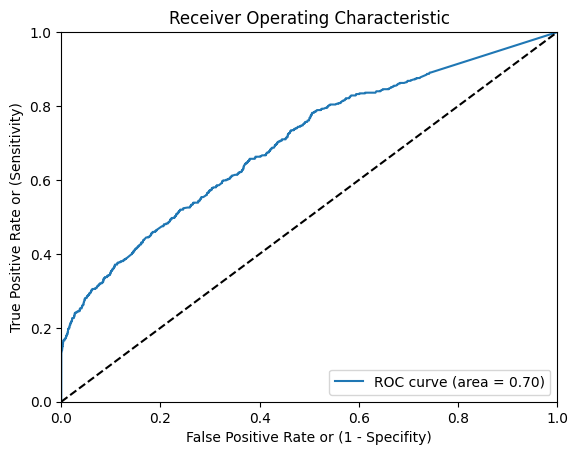

In [205]:
random_seed = 42
cost_sensitive = True

if cost_sensitive:
    weight_dict = {"Negative": 1,
                   "Positive": 5}
    model_class = RandomForestClassifier(class_weight= weight_dict,
                                         random_state= random_seed)
else:
    model_class = RandomForestClassifier(class_weight= None,
                                         random_state= random_seed)
    
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, pos_label = 'Positive')
n_cv_folds = 5

model_rf = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train)

# Evaluate the performance of the model
optimal_threshold = find_optimal_moving_threshold(model = model_rf, X_test = X_test_transformed, y_test = y_test)

__,__,__,__,__,__,f1 = calculate_performance_metrics_rsv(trained_model = model_rf, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold, 
                                                         print_roc = True)


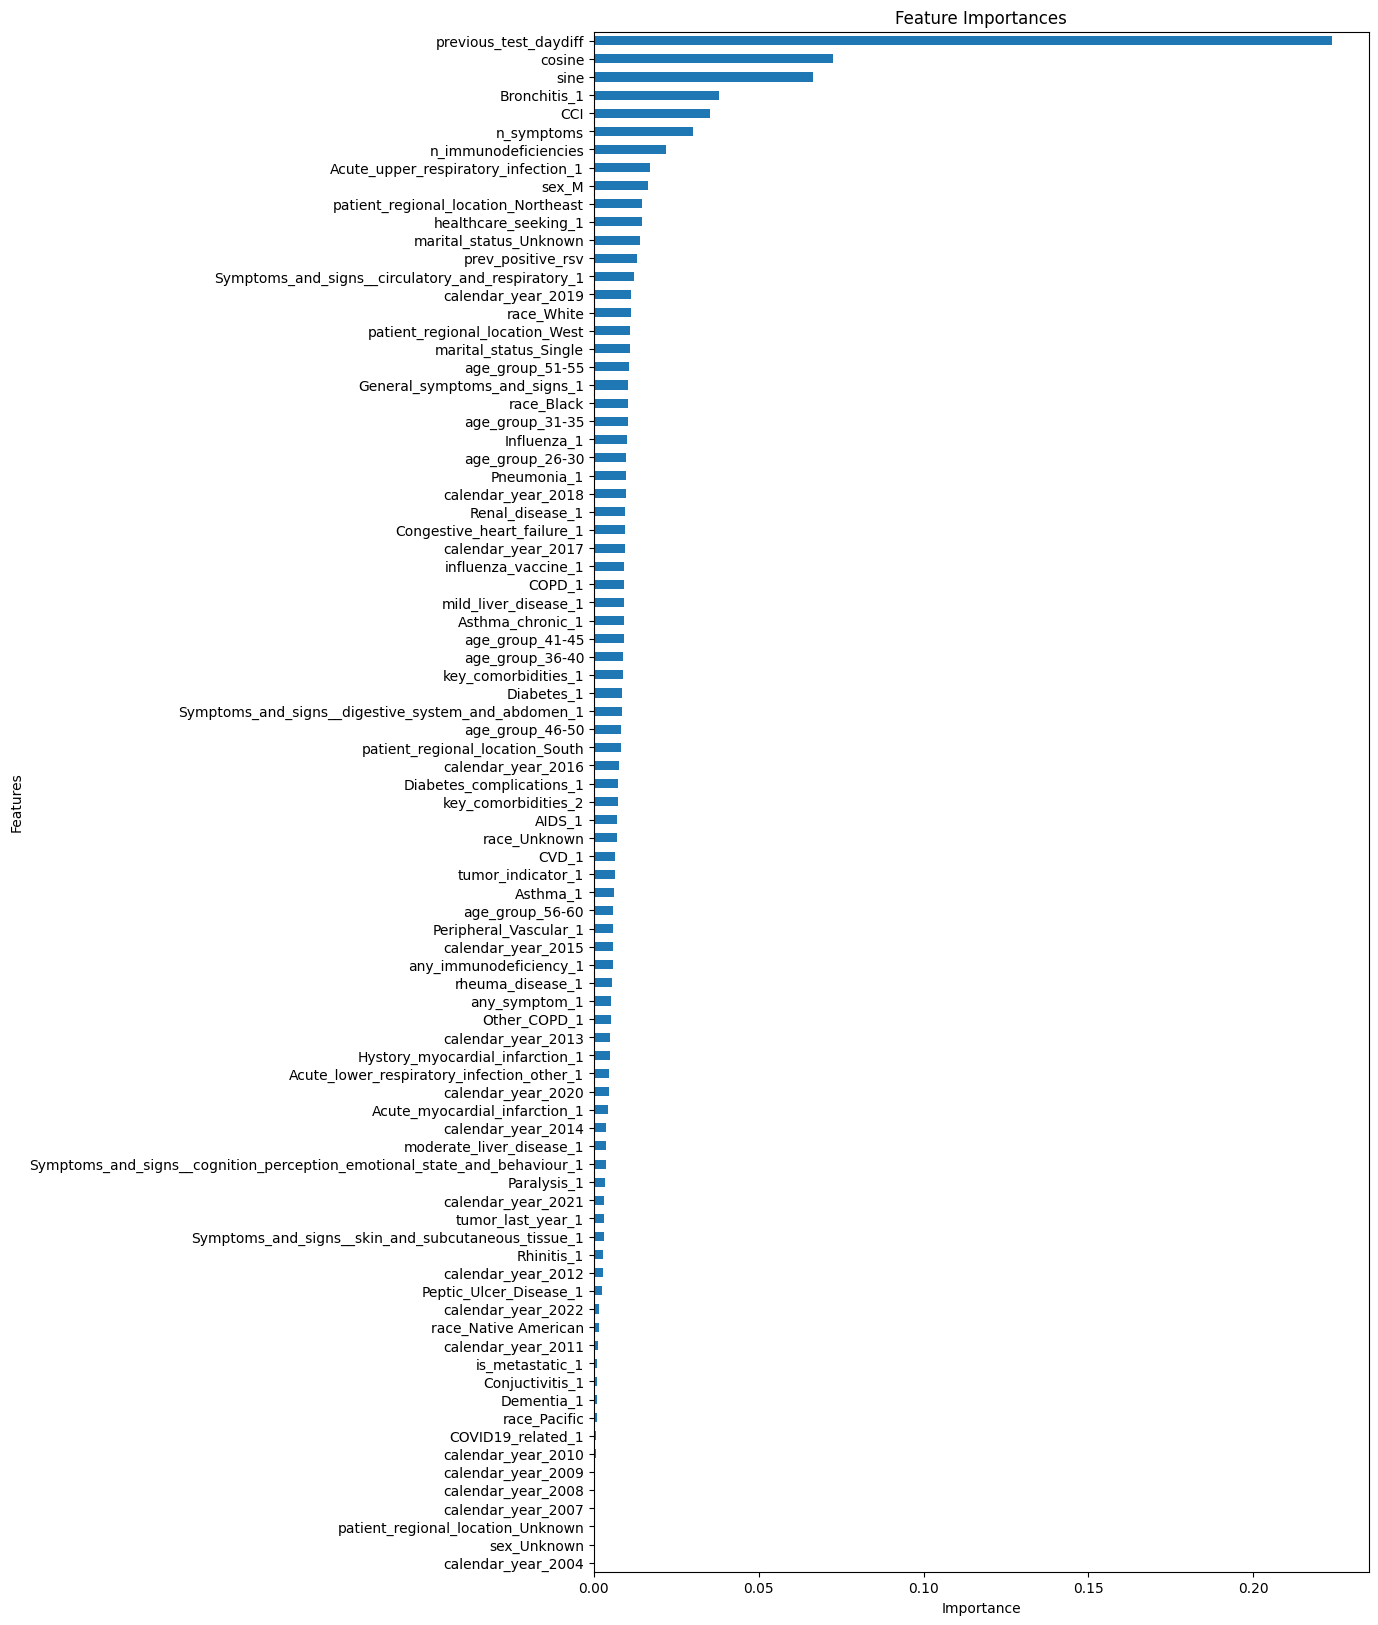

In [206]:
importance_df = feature_importance_rf_rsv(preprocessor_rsv, trained_model = model_rf)

Overall, the three methods point towards the same (roughly) features:

In [ ]:
selected_features = ['sex', 'marital_status', 'patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','']

In [207]:
df1.columns

Index(['RSV_test_result', 'sex', 'race', 'marital_status',
       'patient_regional_location', 'age_group', 'Conjuctivitis',
       'Acute_upper_respiratory_infection', 'Influenza', 'Pneumonia',
       'Bronchitis', 'Acute_lower_respiratory_infection_other', 'Rhinitis',
       'Other_COPD', 'Asthma',
       'Symptoms_and_signs__circulatory_and_respiratory',
       'Symptoms_and_signs__digestive_system_and_abdomen',
       'Symptoms_and_signs__skin_and_subcutaneous_tissue',
       'Symptoms_and_signs__cognition_perception_emotional_state_and_behaviour',
       'General_symptoms_and_signs', 'COVID19_related', 'any_symptom',
       'Acute_myocardial_infarction', 'Hystory_myocardial_infarction',
       'Congestive_heart_failure', 'Peripheral_Vascular', 'CVD', 'COPD',
       'Dementia', 'Paralysis', 'Diabetes', 'Diabetes_complications',
       'Renal_disease', 'mild_liver_disease', 'moderate_liver_disease',
       'Peptic_Ulcer_Disease', 'rheuma_disease', 'AIDS', 'Asthma_chronic',
       'C